In [44]:
import anytree
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import math
import copy

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc



In [67]:
training_data = pd.read_csv('training_1.csv')
validation_data = pd.read_csv('validation_1.csv')
test_data = pd.read_csv('testing_1.csv')


In [68]:
def calculateGini(p1):
    gini = 2*p1*(1-p1)      #calculating gini; formula derivation shown in documentation
    return gini


In [69]:
def calculateEntropy(p1):
    entropy = -1*((p1*math.log2(p1))+((1-p1)*math.log2(1-p1)))  #function for calculating entropy; not used in this code
    return entropy

In [70]:
def calculateInfoGain(left_p1, right_p1, left_total, right_total, root_p1):
    left_weight = left_total/(left_total+right_total)       #calculating the weight of left subtree
    right_weight = right_total/(left_total+right_total)   #calculating the weight of right subtree
    
    left_gini = calculateGini(left_p1)
    right_gini = calculateGini(right_p1)
    weighted_gini = left_weight*left_gini + right_weight*right_gini    #calculating the weighted gini
    root_gini = calculateGini(root_p1)            #calculating gini of parent
    gain_gini = root_gini - weighted_gini       #calculating the gain in gini
    
#    left_entropy = calculateEntropy(left_p1)
#    right_entropy = calculateEntropy(right_p1)
#    weighted_entropy = left_weight*left_entropy + right_weight*right_entropy
#    root_entropy = calculateEntropy(root_p1)
#    gain_entropy = root_entropy - weighted_entropy
    
    return gain_gini
    #return gain_entropy

In [71]:
def computeOptimalSplit(data):           #this function return the position and value of the cell on whose basis data
    max_gain = 0                         #        split such that gain is maximum
    X,Y = data.shape
    temp_gain = K = J = max_val = 0
    count = 0
    data_array = data.values     #creating numpy array from dataframe
    for j in range (1,Y):    #looping on all features(columns)
        for i in range(0,X):     #looping on all rows
            value = data_array[i,j]
            left_class0 = left_class1 = right_class0 = right_class1 = 0
            for k in range(0,X):                              
                temp_data = data_array[k,j]
                count += 1
                if (temp_data<=value):
                    if (data_array[k,0] ==0):
                        left_class0 += 1         #getting the number of instances in left subtree which are of class 0
                    else:
                        left_class1 += 1        #getting the number of instances in left subtree which are of class 1
                else:
                    if (data_array[k,0]==0):
                        right_class0 += 1       #getting the number of instances in right subtree which are of class 0
                    else:
                        right_class1 += 1        #getting the number of instances in left subtree which are of class 1
            left_total = left_class0 + left_class1   #getting total number of instances in left subtree 
            right_total = right_class0 + right_class1  #getting total number of instances in right subtree 
            if(left_total != 0 and right_total != 0):
                left_p1 = left_class0/left_total     # getting probability of class 0 in left subtree
                right_p1 = right_class0/right_total  # getting probability of class 0 in right subtree
                root_p1 = (left_class0 + right_class0)/(left_total + right_total)   #for calculating info gain of parent
                temp_gain = calculateInfoGain(left_p1, right_p1, left_total, right_total, root_p1)  #calculating total gain
            else:
                temp_gain = -1
            if (temp_gain > max_gain):
                max_gain = temp_gain      #evaluating the maximum gain among all nodes
                K = i
                J = j                #K and J are the x-y coordinates of the value in data array whose gain is max
                max_val = value     # max_value is the corresponding value of the cell
    return K, J, max_val               
            
                    
                        
            


In [72]:
def stoppingCond(data):             #this function inputs the dataframe from a node and tells whether the node is pure
    I,J = data.shape
    data_array = data.values
    sum1 = 0
    product = 1
    for i in range (0,I):
        sum1 = sum1 + data_array[i,0]          # reason for calculating sum and product given in documentation
        product = product * data_array[i,0]
    if ((sum1 == 0) or (product == 1)):             #it checks whether all the class values are either 0 or 1
        return True
    else:
        return False
    
    
    
    
        

In [73]:
def createData(data):
    K, J, max_val = computeOptimalSplit(data)
    data_array = data.values       #creating numpy array of the dataframe
    X, Y = data.shape
    node_name = data.columns[J]    #getting the name of the feature at column J
    left_data = []
    right_data = []
    for k in range(0,X):
        data1 = data.loc[k,:].values    #storing all features of a particular row
        if (data_array[k,J]<=max_val):
            left_data.append(data1)       #appending a row to left subtree o right according to condition
        else:
            right_data.append(data1)
    left_data_new = pd.DataFrame(left_data, columns = data.columns)    #creating dataframe for left and right data
    right_data_new = pd.DataFrame(right_data, columns = data.columns)
    left_data_new_modified = left_data_new.drop(node_name, axis = 1)        #dropping Jth column from dataframe
    right_data_new_modified = right_data_new.drop(node_name, axis = 1)
    return left_data_new_modified, right_data_new_modified 

       
    

In [92]:
def build_recurse_tree(node):
    data1 = node.dframe
    if (stoppingCond(data1) != True):
        #split
        lcount = 0
        dframe_left, dframe_right = createData(data1)     #creating a left dataframe and right dataframe from given data
        if(stoppingCond(dframe_left)):
            temp = dframe_left.values
            classify = temp[0,0]
            lcount = lcount + 1
            left_node = Node(None, None, dframe_left, 'leaf_left'+str(lcount), None, classify)    #checking and creating left leaf node
        else:
            K_left, J_left, val_left = computeOptimalSplit(dframe_left)
            left_node = Node(None, None, dframe_left, dframe_left.columns[J_left], val_left, 2)  #creating non-leaf node
            
        if(stoppingCond(dframe_right)):
            temp = dframe_right.values
            classify = temp[0,0]
            lcount = lcount + 1
            right_node = Node(None, None, dframe_right, 'leaf_right'+str(lcount), None, classify)     #checking and creating right leaf node
        else:
            K_right, J_right, val_right = computeOptimalSplit(dframe_right)
            right_node = Node(None, None, dframe_right, dframe_right.columns[J_right], val_right, 2)  #creating non-leaf node
        node.children = [left_node, right_node]    #setting the nodes as child nodes of given node
        
        build_recurse_tree(left_node)    #recursively calling function for building tree
        build_recurse_tree(right_node)
    return node


In [101]:
from anytree import NodeMixin, RenderTree, AsciiStyle, PreOrderIter, PostOrderIter
class Node(NodeMixin):
    def __init__(self, parent, children, dframe, name, threshold, info):
        self.dframe = dframe
        self.parent = None           #creating node class by importing NodeMixin
        self.name = name
        self.threshold = threshold
        self.info = info      #info value 2: non leaf node; 0: benign; 1: malignant
        self.children = []
        
        
K, J, max_val = computeOptimalSplit(training_data)
#data_array = training_data.values       #creating numpy array of the dataframe
node_name = training_data.columns[J]    #getting the name of the feature at column J
count = 1
root = Node(None, None, training_data, node_name, max_val, 2)   #creating root node
tree = build_recurse_tree(root)       #building decision tree
#tree_copy = tree           #storing multiple copies of the tree for further use
tree_copy1 = copy.deepcopy(tree)
tree_copy4 = copy.deepcopy(tree)
tree_copy5 = copy.deepcopy(tree)


In [76]:
#-----------------------------------------PRINTING TREE-------------------------------------------------

In [94]:
for pre, _, node in RenderTree(tree):
    treestr = u"%s%s" % (pre, node.name)
    print(treestr.ljust(8), node.threshold, node.info)    #function to print the tree using Anytree standard function


Perimeter__max 109.4 2
├── Number_of_Concavities__max 0.1708 2
│   ├── Area__mean 689.5 2
│   │   ├── Texture__max 29.16 2
│   │   │   ├── Area__stddev 44.74 2
│   │   │   │   ├── leaf_left1 None 0.0
│   │   │   │   └── Radius__mean 9.731 2
│   │   │   │       ├── leaf_left1 None 0.0
│   │   │   │       └── leaf_right2 None 1.0
│   │   │   └── Number_of_Concavities__mean 0.04408 2
│   │   │       ├── Texture__stddev 0.8265 2
│   │   │       │   ├── leaf_left1 None 1.0
│   │   │       │   └── Perimeter__stddev 1.4569999999999999 2
│   │   │       │       ├── Texture 22.47 2
│   │   │       │       │   ├── leaf_left1 None 1.0
│   │   │       │       │   └── leaf_right2 None 0.0
│   │   │       │       └── leaf_right1 None 0.0
│   │   │       └── leaf_right1 None 1.0
│   │   └── leaf_right1 None 1.0
│   └── Radius__mean 9.029 2
│       ├── leaf_left1 None 0.0
│       └── leaf_right2 None 1.0
└── Number_of_Concavities__mean 0.04835 2
    ├── Number_of_Concavities__stddev 0.009443 2
    │  

In [78]:
#-------------------------------------------------PRUNING-------------------------------------------------

In [79]:
def calculateClass(data):
    X, Y = data.shape
    count0 = 0
    count1 = 0
    data_array = data.values     #converting dataframe to a numpy array for further calculations
    for i in range(0,X):
        if(data_array[i,0]==0):
            count0 += 1
        else:
            count1 += 1
    if(count0 > count1):     #calculating the number of instances of class 0 and class 1 and returning the greater of the two
        
        return 0
    else:
        return 1


    
    
    

In [80]:
def validate_tree(data3, node):
    if(node.is_leaf == False):
        for j in range(0,Y):                #this function is used to run decision tree on the validation set
            if(attribute_list[j]==node.name):
                if(data3[j]<= node.threshold):
                    node = node.children[0]          #moving to left subtree
                    break
                else:
                    node = node.children[1]             #moving to right subtree
                    break
        return validate_tree(data3, node)    
    else:
        result2 = node.info                 #if leaf node is reached, then info of the node gives the resulant class
        return result2
    
      
           

In [81]:
trueValid_array = validation_data.iloc[:,0].values
def validate_tree_1(inputData, tree_copy):
    result_array1 = []
    result2 = 0
    for k in range(0,X):
        data3 = inputData.iloc[k,:].values          #this function is simply used to pass the validation dataset row wise
        result2 = validate_tree(data3, tree_copy)
        result_array1.append(result2)
    return result_array1


In [103]:
X, Y = validation_data.shape
#result_array1 = []
attribute_list = validation_data.columns       #returns the list of all feature names in the validation data
validation_data_array = validation_data.values
trueValid_array = validation_data.iloc[:,0].values  #returns the list of true class values
max_accuracy = 0
validation_accuracy_list = []
validate_fscore_list = []
train_accuracy_list = []
train_fscore_list = []
def tree_traversal(tree_copy1):
    temp_accuracy = 0
    max_accuracy = 0
    F1Score = 0
    Node2 = Node(None, None, None, None, None, None)   #empty node
    for node in PreOrderIter(tree_copy1):      #Pre Order Traversal of the tree
        #result_array1 = []
        if(node.is_leaf == False):           #checking for leaf node
            left, right = node.children
            node.children = []               #pruning the children of that node
            dframe = node.dframe
            node.info = calculateClass(dframe)     # calculating class of new leaf node
            result_array1 = validate_tree_1(validation_data, tree_copy1)    #getting the array of predicted class
            temp_accuracy = accuracy_score(trueValid_array, result_array1)  #calculating accuracy using standard python library
            #print(temp_accuracy)
            if (temp_accuracy >= max_accuracy):
                max_accuracy = temp_accuracy      #storing the max accuracy
                Node2 = node                     #storing the corresponding node
                #print(node.name)
                #F1Score = f1_score(trueValid_array, result_array1)
            node.children = [left, right]        #re attaching the child nodes for next iteration
            node.info = 2
    #print(max_accuracy)
    validation_accuracy_list.append(max_accuracy)
    #validate_fscore_list.append(F1Score)
    return Node2

    
            




In [104]:
result_array_test = []
attribute_list = test_data.columns
test_data_array = test_data.values


    
def test_tree(data2, node):
    if(node.is_leaf == False):
        for j in range(0,Y):
            if(attribute_list[j]==node.name):
                if(data2[j]<= node.threshold):
                    node = node.children[0]
                    break
                else:
                    node = node.children[1]
                    break
        return test_tree(data2, node)    
    else:
        return node.info
def test_tree1(inputData, tree_copy5):
    X_test, Y_test = inputData.shape
    result_array_test = []
    result4 = 0
    for k in range(0,X_test):
        data3 = inputData.iloc[k,:].values          #this function is simply used to pass the validation dataset row wise
        result4 = test_tree(data3, tree_copy5)
        result_array_test.append(result4)
    return result_array_test


In [105]:
result_array_train = []
attribute_list = training_data.columns
training_data_array = training_data.values
X_train, Y_train = training_data.shape

    
def train_tree(data7, node):
    if(node.is_leaf == False):
        for j in range(0,Y_train):
            if(attribute_list[j]==node.name):
                if(data2[j]<= node.threshold):
                    node = node.children[0]
                    break
                else:
                    node = node.children[1]
                    break
        return train_tree(data7, node)    
    else:
        return node.info
def train_tree1(inputData_train, tree_copy7):
    result_array_train = []
    result7 = 0
    for k in range(0,X_train):
        data6 = inputData_train.iloc[k,:].values          #this function is simply used to pass the validation dataset row wise
        result6 = test_tree(data6, tree_copy7)
        result_array_train.append(result6)
    return result_array_train

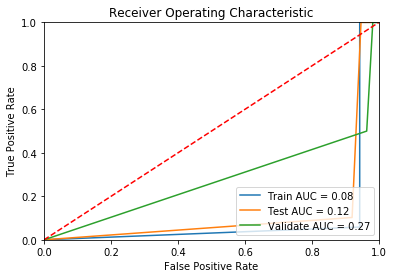

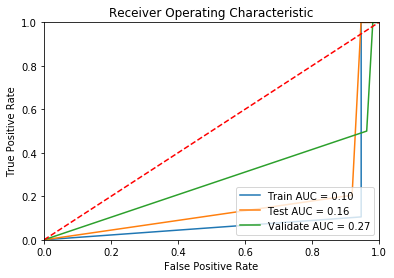

Perimeter__max
[0.34210526315789475, 0.03508771929824561, 0.30701754385964913, 0.03508771929824561, 0.0, 0.0]
[]
[0.4371859296482412, 0.41457286432160806, 0.0, 0.4371859296482412, 0.41457286432160806, 0.0]
[9, 7, 1]


In [107]:
leaf_count_array = []
test_true_array = test_data.iloc[:,0].values
train_true_array = training_data.iloc[:,0].values
validate_true_array = validation_data.iloc[:,0].values
test_accuracy_list = []
validate_accuracy_list = []

def pruneSingleGreedyNode(tree_copy1):
    Node2 = tree_traversal(tree_copy1)     #getting the node that will be pruned
    leaf_count = 0
    for node3 in PreOrderIter(tree_copy1):
        if(node3 == Node2):
            dframe = node.dframe
            node3.children = []
            node.info = calculateClass(dframe)
    if (tree_copy1.is_leaf == False):
        for pre, _, nodeX in RenderTree(tree_copy1):       # printing the pruned tree
            #treestr = u"%s%s" % (pre, nodeX.name)
            #print(treestr.ljust(8), nodeX.threshold, nodeX.info)
            if(nodeX.is_leaf == True):
                leaf_count += 1
        #print('\n \n \n')
        leaf_count_array.append(leaf_count)
        test_predictions = test_tree1(test_data, tree_copy1)
        
        test_accuracy = accuracy_score(test_true_array, test_predictions)
        #test_fscore = f1_score(test_true_array, test_predictions)
        
        test_accuracy_list.append(test_accuracy)
        #test_fscore_list.append(test_fscore)
        
        train_predictions = train_tree1(training_data, tree_copy1)
        
        train_accuracy = accuracy_score(train_true_array, train_predictions)
        #train_fscore = f1_score(train_true_array, train_predictions)
        
        train_accuracy_list.append(train_accuracy)
        #train_fscore_list.append(train_fscore)
        
        validate_predictions = test_tree1(validation_data, tree_copy1)
        
        validate_accuracy = accuracy_score(validate_true_array, validate_predictions)
        #validate_fscore = f1_score(validate_true_array, validate_predictions)
        
        test_accuracy_list.append(validate_accuracy)
        #validate_fscore_list.append(validate_fscore)
        
        fpr_train, tpr_train, thresholds_train = roc_curve(train_true_array, train_predictions)
        precision_train, recall_train, thresholds1_train = precision_recall_curve(train_true_array, train_predictions)
        roc_auc_train = auc(fpr_train,tpr_train)
        #pr_auc_train = auc(precision_train, recall_train)
        
        fpr_test, tpr_test, thresholds_test = roc_curve(test_true_array, test_predictions)
        precision_test, recall_test, thresholds1_test = precision_recall_curve(test_true_array, test_predictions)
        roc_auc_test = auc(fpr_test,tpr_test)
        #pr_auc_test = auc(precision_test, recall_test)
        
        fpr_validate, tpr_validate, thresholds_validate = roc_curve(validate_true_array, validate_predictions)
        precision_validate, recall_validate, thresholds_ = precision_recall_curve(validate_true_array, validate_predictions)
        roc_auc_validate = auc(fpr_validate,tpr_validate)
        #pr_auc_validate = auc(precision_validate, recall_validate)
        
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr_train, tpr_train, label = 'Train AUC = %0.2f' %roc_auc_train )
        plt.plot(fpr_test, tpr_test, label = 'Test AUC = %0.2f' % roc_auc_test)
        plt.plot(fpr_validate, tpr_validate, label = 'Validate AUC = %0.2f' % roc_auc_validate)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

#         plt.title('Precision Recall Curve')
#         plt.plot(recall_train, precision_train, label = 'Train AUC = ')
#         plt.plot(recall_test, precision_test, label = 'Test AUC = %0.2f' % pr_auc_test)
#         plt.plot(recall_validate, precision_validate, label = 'Validate AUC = %0.2f' % pr_auc_validate)
#         plt.legend(loc = 'lower right')
#         #plt.plot([0, 1], [0, 1],'r--')
#         plt.xlim([0, 1])
#         plt.ylim([0, 1])
#         plt.ylabel('Precision')
#         plt.xlabel('Recall')
#         plt.show()
        
        pruneSingleGreedyNode(tree_copy1)
    else:
        print(tree_copy1.name)
        leaf_count_array.append(1)
        test_predictions = test_tree1(test_data, tree_copy1)
        test_accuracy = accuracy_score(test_true_array, test_predictions)
        test_accuracy_list.append(test_accuracy)
        #test_fscore = f1_score(test_true_array, test_predictions)
        #test_fscore_list.append(test_fscore)
        
        train_predictions = train_tree1(training_data, tree_copy1)
        train_accuracy = accuracy_score(train_true_array, train_predictions)
        #train_fscore = f1_score(train_true_array, train_predictions)
        train_accuracy_list.append(train_accuracy)
        #train_fscore_list.append(train_fscore)
        
        validate_predictions = test_tree1(validation_data, tree_copy1)        
        validate_accuracy = accuracy_score(validate_true_array, validate_predictions)
        #validate_fscore = f1_score(validate_true_array, validate_predictions)        
        test_accuracy_list.append(validate_accuracy)
        #validate_fscore_list.append(validate_fscore)
        
pruneSingleGreedyNode(tree_copy4)
print(test_accuracy_list)
#print(test_fscore_list)
print(validate_accuracy_list)
#print(validate_fscore_list)
print(train_accuracy_list)
#print(train_fscore_list)
print(leaf_count_array)

ValueError: x and y must have same first dimension, but have shapes (3,) and (6,)

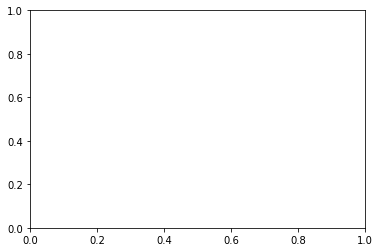

In [108]:
plt.plot(leaf_count_array, test_accuracy_list, label='TEST')
plt.plot(leaf_count_array, train_accuracy_list, label='TRAIN')
plt.plot(leaf_count_array, validation_accuracy_list, label='VALIDATION')
plt.ylabel('ACCURACY')
plt.xlabel('LEAF NODE COUNT')
#plt.plot(range(5), range(5), label=)
plt.legend()

In [97]:
from graphviz import Digraph
def insertToGVPostOrder(node):
    if node.children[0].is_leaf== True and  node.children[1].is_leaf==True:
        dg.node(str(node.name), 'label='+str(node.name))
    if node.children[0].is_leaf== False:
        insertToGVPostOrder(node.children[0])    
    if node.children[1].is_leaf== False:
        insertToGVPostOrder(node.children[1])
    
    if node.children[0].is_leaf== False and  node.children[1].is_leaf== False:
        dg.node(str(node.threshold)+str(node.name), 'label='+str(node.name)+'\n'+str(node.threshold))        
        dg.edge(str(node.info)+str(node.name), str(node.children[0].name), label='False')    
        dg.edge(str(node.info)+str(node.name), str(node.children[1].name), label='True')
    
    return dg

In [98]:
dg = Digraph('Tree', filename='abc.gv')
dg = insertToGVPostOrder(tree)
dg.render('vis/bcd.gv', view=True) 
'vis/tree.pdf'

'vis/tree.pdf'

In [ ]:
# ---------------------------------------TESTING-----------------------------------------------------

In [189]:
'''
X, Y = test_data.shape
result_array_test = []
attribute_list = test_data.columns
test_data_array = test_data.values


    
def test_tree(data2, node):
    if(node.info == 2):
        for j in range(0,Y):
            if(attribute_list[j]==node.name):
                if(data2[j]<= node.threshold):
                    node = node.children[0]
                else:
                    node = node.children[1]
        test_tree(data2, node)    
    else:
        result_array_test.append(node.info)
def test_tree1(inputData, tree_copy5):
    X_test, Y_test = inputData.shape
    result_array_test = []
    result4 = 0
    for k in range(0,X_test):
        data3 = inputData.iloc[k,:].values          #this function is simply used to pass the validation dataset row wise
        result2 = test_tree(data3, tree_copy5)
        result_array_test.append(result4)
    return result_array_test
        
for i in range(0,X):
    data2 = test_data.iloc[i,:].values
    test_tree(data2, tree_copy)
'''    

In [ ]:
#-----------------------------------PRINTING SCORES------------------------------------------------------------------

Accuracy: 0.6578947368421053
Precision: 0.0
Recall: 0.0
F Score: 0.0
False Positive Rate: [0. 1.]
True Positive Rate: [0. 1.]
Area Under Curve ROC: 0.5
Area Under Curve PR: 0.32894736842105265


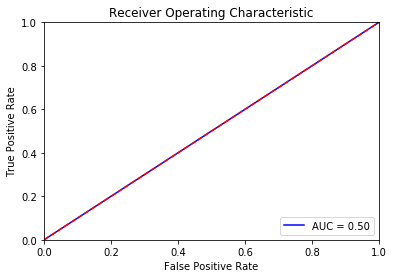

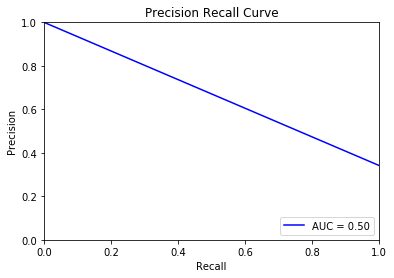

In [191]:
'''
def print_scores(true_array, result_array, count):
    AccuracyScore = accuracy_score(true_array, result_array)
    PrecisionScore = precision_score(true_array, result_array)
    RecallScore = recall_score(true_array, result_array)
    FScore = f1_score(true_array, result_array)
    
    
    print('---------------Iteration-------------------', count)
    print('Accuracy:', str(AccuracyScore))
#     print('Precision:', str(PrecisionScore))
#     print('Recall:', str(RecallScore))
#     print('F Score:', str(FScore))
#     print('False Positive Rate:', fpr)
#     print('True Positive Rate:', tpr)
#     #print('Thresholds:', thresholds)
#     #print(precision1)
#     #print(recall1)
#     print('Area Under Curve ROC:', roc_auc)
#     print('Area Under Curve PR:', pr_auc)


    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.title('Precision Recall Curve')
    plt.plot(recall1, precision1, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
'''    

In [183]:
from anytree.exporter import DotExporter
# graphviz needs to be installed for the next line!
DotExporter(tree).to_picture("Tree.png")
